### Competition Model

$$u' = u(1 - a_1  u - a_2  v)$$
$$v' = rv(1 -b_1 u - b_2 v)$$
with $u_0 = 2$ and $v_0 = 1$

##### Workflow Overview

1. Define the **problem domain**, by using the `fbpinns.domains.RectangularDomainND` class
2. Define the **ODE** to solve, and its **problem constraints**, by defining our own `fbpinns.problems.Problem` class
3. Define the **domain decomposition** used by the FBPINN, by using the `fbpinns.decompositions.RectangularDecompositionND` class
4. Define the **neural network** placed in each subdomain, by using the `fbpinns.networks.FCN` class
5. Pass these classes and their initialisation values to a `fbpinns.constants.Constants` object
6. Start the FBPINN training by instantiating a `fbpinns.trainer.FBPINNTrainer` using the `Constants` object.

##### Step 1: Problem Domain

In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
from fbpinns.domains import RectangularDomainND

domain = RectangularDomainND
domain_init_kwargs = dict(
    xmin = np.array([0.,]),
    xmax = np.array([24.,])
)

domain_init_kwargs

{'xmin': array([0.]), 'xmax': array([24.])}

Step 2: Define the ODE to solve

In [3]:
import jax.numpy as jnp
from fbpinns.problems import Problem

In [4]:
from scipy.integrate import odeint
from scipy.interpolate import interp1d

class CompetitionModel(Problem):

    @staticmethod
    def init_params(params, u0, v0):
        
        r, a1, a2, b1, b2 = params 
        static_params = {
            "dims":(2,1),   # dims of solution and problem
            "r_true":r,
            "a1_true":a1,
            "a2_true":a2,
            "b1_true":b1,
            "b2_true":b2,
            "u0":u0,
            "v0":v0,
        }
        trainable_params = {
            "r":jnp.array(0.),
            "a1":jnp.array(0.),
            "a2":jnp.array(0.),
            "b1":jnp.array(0.),
            "b2":jnp.array(0.),
        }
        return static_params, trainable_params
    
    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        # Physics Loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0, ()),  
            (1, ()),  
            (0, (0,)), 
            (1, (1,)),  
        )


        # Boundary Loss
        x_batch_boundary = jnp.array([0.]).reshape((1,1))
        u0 = all_params["static"]["problem"]["u0"]
        v0 = all_params["static"]["problem"]["v0"]
        u_boundary = jnp.array([u0]).reshape((1,1))
        v_boundary = jnp.array([v0]).reshape((1,1))
        required_ujs_boundary = (
            (0, ()),  
            (1, ()), 
        )


        # Data Loss
        x_batch_data = jnp.linspace(0,10,50).astype(float).reshape((-1,1))
        r_true, a1_true, a2_true, b1_true, b2_true = [all_params['static']["problem"][key] for key in ('r_true', 'a1_true', 'a2_true', 'b1_true', 'b2_true')]
        params = (r_true, a1_true, a2_true, b1_true, b2_true)
        solution = odeint(CompetitionModel.model, [u0,v0], x_batch_data.reshape((-1,)), args=(params,))
        u_data = solution[:,0]
        v_data = solution[:,1]
        required_ujs_data = (
            (0, ()), 
            (1, ()),  
        )


        return [[x_batch_phys, required_ujs_phys],
                [x_batch_boundary, u_boundary, v_boundary, required_ujs_boundary],
                [x_batch_data, u_data, v_data, required_ujs_data]]
    
    @staticmethod
    def loss_fn(all_params, constraints):
        
        r, a1, a2, b1, b2 = [all_params['trainable']["problem"][key] for key in ('r', 'a1', 'a2', 'b1', 'b2')]

        # Physics loss
        _, u, v, ut, vt = constraints[0]
        phys1 = jnp.mean((ut - u + a1*u**2 + a2*u*v)**2)
        phys2 = jnp.mean((vt - r*v + r*b1*u*v + r*b2*v**2)**2)
        phys = phys1 + phys2

        # Boundary loss
        _, uc, vc, u, v = constraints[1]
        boundary = 1e6*jnp.mean((u-uc)**2) + 1e6*jnp.mean((v-vc)**2)

        # Data Loss
        _, ud, vd, u, v = constraints[2]
        u = u.reshape(-1) 
        v = v.reshape(-1) 
        data = 1e6*jnp.mean((u-ud)**2) + 1e6*jnp.mean((v-vd)**2)
        
        return phys + boundary + data

    @staticmethod
    def model(y, t, params):
        """
        Compute the derivatives of the system at time t.
        
        :param y: Current state of the system [u, v].
        :param t: Current time.
        :param params: Parameters of the model (a1, a2, b1, b2, r).
        :return: Derivatives [du/dt, dv/dt].
        """
        u, v = y  
        r, a1, a2, b1, b2 = params  
        
        # Define the equations
        du_dt = u * (1 - a1 * u - a2 * v)
        dv_dt = r * v * (1 - b1 * u - b2 * v)
        
        return [du_dt, dv_dt]
    
    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        r, a1, a2, b1, b2 = [all_params['static']["problem"][key] for key in ('r_true', 'a1_true', 'a2_true', 'b1_true', 'b2_true')]
        u0 = all_params["static"]["problem"]["u0"]
        v0 = all_params["static"]["problem"]["v0"]
        params = [r, a1, a2, b1, b2]
        
        t = jnp.arange(0, 25.02, 0.02)  
        
        # Solve the system 
        solution = odeint(CompetitionModel.model, [u0, v0], t, args=(params,))
        
        # Interpolation 
        u_interp = interp1d(t, solution[:, 0], kind='cubic')
        v_interp = interp1d(t, solution[:, 1], kind='cubic')
        
        u_data = u_interp(x_batch.flatten())
        v_data = v_interp(x_batch.flatten())
        
        # Combine 
        combined_solution = jnp.vstack((u_data, v_data)).T
        if batch_shape:
            combined_solution = combined_solution.reshape(batch_shape + (2,))
        
        return combined_solution


# solution = odeint(self._model, initial_conditions, t_span)
# from scipy.integrate import odeint
    
problem = CompetitionModel
params = [0.5, 0.7, 0.3, 0.3, 0.6]
# params = [0.5, 0.3, 0.6, 0.7, 0.3]
problem_init_kwargs = dict(
    params=params, u0=2, v0=1,
)


Step3: Define the domain decomposition used by the FBPINN

In [5]:
from fbpinns.decompositions import RectangularDecompositionND

decomposition = RectangularDecompositionND # use a rectangular domain decomposition

decomposition_init_kwargs = dict(
    subdomain_xs = [np.linspace(0,24,15)],
    subdomain_ws = [(24/12)*np.ones((15,))],
    unnorm = (0., 1.),
)
decomposition_init_kwargs

{'subdomain_xs': [array([ 0.        ,  1.71428571,  3.42857143,  5.14285714,  6.85714286,
          8.57142857, 10.28571429, 12.        , 13.71428571, 15.42857143,
         17.14285714, 18.85714286, 20.57142857, 22.28571429, 24.        ])],
 'subdomain_ws': [array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])],
 'unnorm': (0.0, 1.0)}

Step4: Define the neural network placed in each subdomain

In [6]:
from fbpinns.networks import FCN

network = FCN# place a fully-connected network in each subdomain
network_init_kwargs=dict(
    layer_sizes=[1,32,2],# with 2 hidden layers
)

Step 5: Create a constants object

In [7]:
from fbpinns.constants import Constants

c = Constants(
    domain=domain,
    domain_init_kwargs=domain_init_kwargs,
    problem=problem,
    problem_init_kwargs=problem_init_kwargs,
    decomposition=decomposition,
    decomposition_init_kwargs=decomposition_init_kwargs,
    network=network,
    network_init_kwargs=network_init_kwargs,
    ns=((2000,),),# use 200 collocation points for training
    n_test=(500,),# use 500 points for testing
    n_steps=50000,# number of training steps
    clear_output=True,
)

print(c)

run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0.]), 'xmax': array([24.])}
problem: <class '__main__.CompetitionModel'>
problem_init_kwargs: {'params': [0.5, 0.7, 0.3, 0.3, 0.6], 'u0': 2, 'v0': 1}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([ 0.        ,  1.71428571,  3.42857143,  5.14285714,  6.85714286,
        8.57142857, 10.28571429, 12.        , 13.71428571, 15.42857143,
       17.14285714, 18.85714286, 20.57142857, 22.28571429, 24.        ])], 'subdomain_ws': [array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])], 'unnorm': (0.0, 1.0)}
network: <class 'fbpinns.networks.FCN'>
network_init_kwargs: {'layer_sizes': [1, 32, 2]}
n_steps: 50000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs: {}
ns: ((2000,),)
n_test: (500,)
sampler: grid
optimiser: <function adam at 0x000001834CF351C0>
optimiser_kwargs: {'lea

Step 6: Train the FBPINNs using FBPINNTrainer

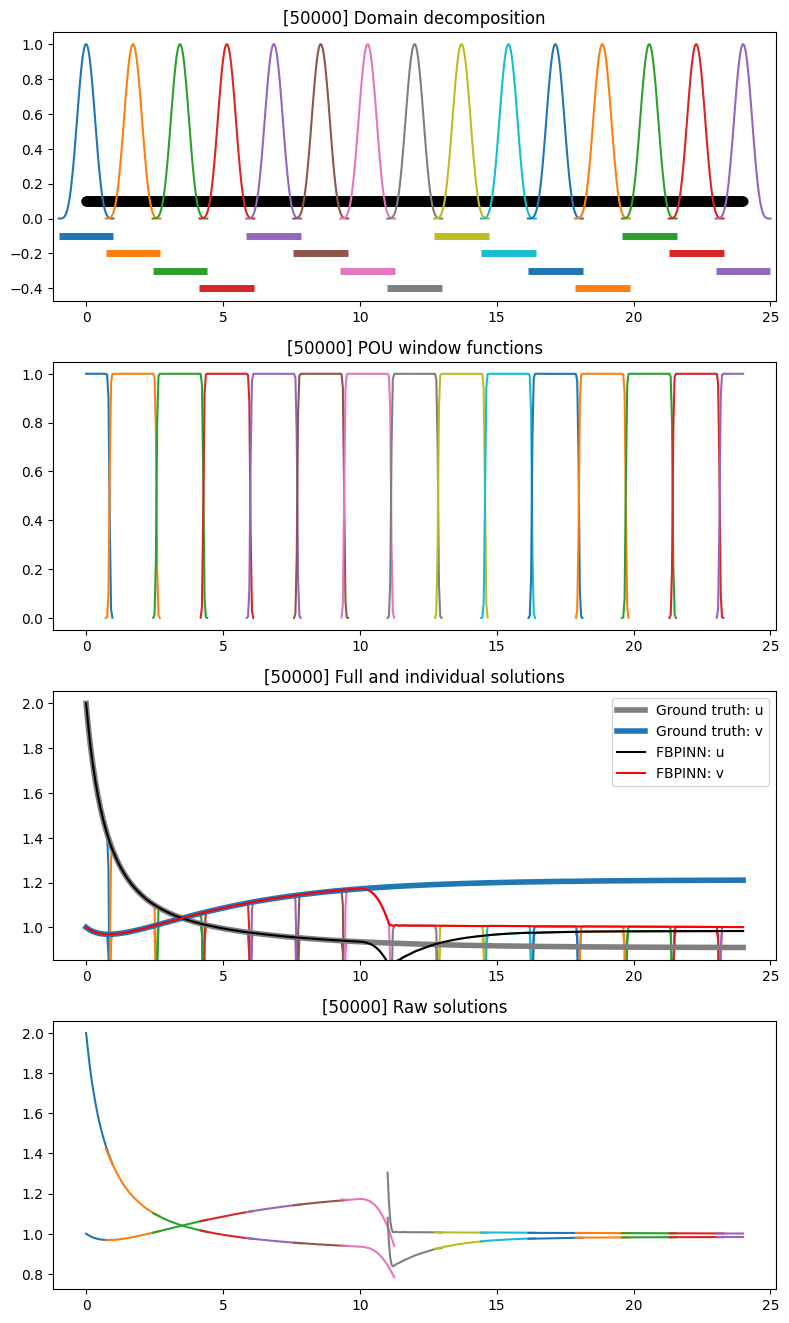

[INFO] 2024-02-16 19:41:27 - [i: 50000/50000] Training complete


"\nFound the bug, it's in the $plot_trainer_1D.py$ function, \nspecifically whit _lim() and _plot_setup() functions to look into.\n\n"

In [8]:
from fbpinns.trainers import FBPINNTrainer

run = FBPINNTrainer(c)
all_params = run.train()

### TODO
"""
Found the bug, it's in the $plot_trainer_1D.py$ function, 
specifically whit _lim() and _plot_setup() functions to look into.

"""

In [9]:
r, a1, a2, b1, b2 = [all_params['trainable']["problem"][key] for key in ('r', 'a1', 'a2', 'b1', 'b2')]
print(r, a1, a2, b1, b2)

r, a1, a2, b1, b2 = [all_params['static']["problem"][key] for key in ('r_true', 'a1_true', 'a2_true', 'b1_true', 'b2_true')]
print(r, a1, a2, b1, b2)

-0.01638648 0.67444354 0.33592516 0.5584958 0.42244968
0.5 0.7 0.3 0.3 0.6


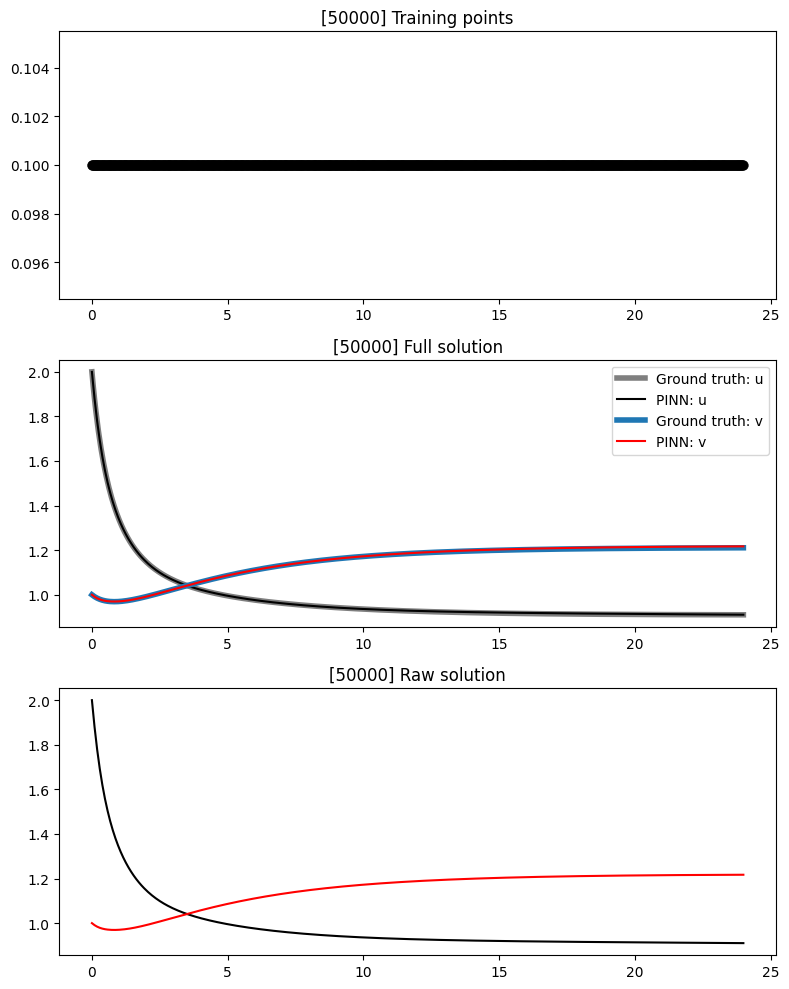

[INFO] 2024-02-16 19:42:13 - [i: 50000/50000] Training complete


In [10]:
from fbpinns.trainers import PINNTrainer

c["network_init_kwargs"] = dict(layer_sizes=[1,5,5,5,2]) # use a larger neural network
run = PINNTrainer(c)
pinn_out = run.train() # start training a PINN on the same problem

In [11]:
r, a1, a2, b1, b2 = [all_params['trainable']["problem"][key] for key in ('r', 'a1', 'a2', 'b1', 'b2')]
print(r, a1, a2, b1, b2)
r, a1, a2, b1, b2 = [pinn_out['trainable']["problem"][key] for key in ('r', 'a1', 'a2', 'b1', 'b2')]
print(r, a1, a2, b1, b2)
r, a1, a2, b1, b2 = [all_params['static']["problem"][key] for key in ('r_true', 'a1_true', 'a2_true', 'b1_true', 'b2_true')]
print(r, a1, a2, b1, b2)

-0.01638648 0.67444354 0.33592516 0.5584958 0.42244968
0.48373705 0.70104194 0.29776636 0.3061365 0.5924759
0.5 0.7 0.3 0.3 0.6
